# QCoDeS Example with Itacho

In this notebook, we show how to use Itacho in a simple setup. We sweep the current using a Keithley 2614B sourcemeter as the current source. Itacho 1211 will convert the current to voltage and we readout the voltage using a DMM Agilent 34401A. Our test setup is as the following picture:

![title](../files/ithaco_setup.png)

### Required imports

In [1]:
import time

from qcodes.dataset import (
    do1d,
    initialise_or_create_database_at,
    load_by_run_spec,
    load_or_create_experiment,
    plot_dataset,
)
from qcodes.instrument_drivers.agilent import Agilent34401A
from qcodes.instrument_drivers.ithaco import Ithaco1211
from qcodes.instrument_drivers.Keithley import Keithley2614B

In [2]:
from qcodes.logger import start_all_logging

start_all_logging()

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\QCoDeS_Public\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\QCoDeS_Public\.qcodes\logs\201109-10868-qcodes.log


### Connecting to the instruments

In [3]:
a1 = Agilent34401A("Agilent1", "GPIB0::4::INSTR")
k1 = Keithley2614B("Keithley", "GPIB0::26::INSTR")

Connected to: HEWLETT-PACKARD 34401A (serial:0, firmware:10-5-2) in 0.21s
Connected to: Keithley Instruments Inc. 2614B (serial:4305420, firmware:3.2.2) in 0.08s


Itacho QCoDeS driver is only a virtual driver without any communication with the instrument. The instrument setting are only controlled via the front and back panel and the used QCoDeS setting must match its corresponding setting on the panel. Now, we instantiate an instance of the instrument:

In [4]:
camp = Ithaco1211("camp")

### Configuration

We set Ampere per Volt Sensitivity here, which match with the setting on the instrument panel (the rest of the setting are set according to their default values in the driver): 

In [5]:
camp.sens.set(1e-4)

Now, we use CurrentParameter class of Itacho to setup the following parameter, which is showing the fed current to the instantiated camp and converted voltage sent to our connected DMM via a1.volt.

In [6]:
curr = Ithaco1211.CurrentParameter(a1.volt, camp)

Let's look at the present value of curr (the sourcemeter is not connected yet):

In [7]:
curr()

(6.409e-05, -6.4090000000000005e-09)

The current value is practically zero. The voltage value is the current value divided by 1e-4 A/V according to the setting camp.sens.set(1e-4). Thus, Itacho converts the feed to voltage and amplifies it. Let's look at the units of curr:

In [8]:
curr.units

('V', 'A')

Our connected DMM reads a similar voltage value:

In [9]:
a1.volt()

6.4838e-05

We set the integration time of our DMM as below:

In [10]:
a1.NPLC.set(1)

Let's look at the snapshot of our created Itacho instance

In [11]:
camp.snapshot()

{'functions': {},
 'submodules': {},
 '__class__': 'qcodes.instrument_drivers.ithaco.Ithaco_1211.Ithaco_1211',
 'parameters': {'IDN': {'__class__': 'qcodes.instrument.parameter.Parameter',
   'full_name': 'camp_IDN',
   'value': None,
   'raw_value': None,
   'ts': None,
   'label': 'IDN',
   'unit': '',
   'vals': '<Anything>',
   'post_delay': 0,
   'instrument': 'qcodes.instrument_drivers.ithaco.Ithaco_1211.Ithaco_1211',
   'instrument_name': 'camp',
   'inter_delay': 0,
   'name': 'IDN'},
  'sens': {'__class__': 'qcodes.instrument.parameter.Parameter',
   'full_name': 'camp_sens',
   'value': 0.0001,
   'raw_value': 0.0001,
   'ts': '2020-11-09 12:02:45',
   'label': 'Sensitivity',
   'unit': 'A/V',
   'vals': '<Enum: {1e-09, 1e-05, 1e-08, 1e-10, 0.0001, 0.001, 1e-07, 1e-06, 1e-11}>',
   'post_delay': 0,
   'instrument': 'qcodes.instrument_drivers.ithaco.Ithaco_1211.Ithaco_1211',
   'instrument_name': 'camp',
   'inter_delay': 0,
   'name': 'sens'},
  'invert': {'__class__': 'qcode

### Setting up qcodes database and performing a simple measurement

Now, we want to feed our Itacho using our Keithley sourcemeter and run a simple qcodes measurement to see the output of the swept values passing through Itacho (for knowing how our sourcemeter works, you can refer to its qcodes notebook in the following:
[Qcodes example with Keithley 2600][mylink]

[mylink]: ./Qcodes%20example%20with%20Keithley%202600.ipynb

We initilize a database named "itacho_db.db" and save our measured data there. Then, we create an experiment named "Itacho_measurement" or load it if is already created:

In [12]:
initialise_or_create_database_at("itacho_db.db")
exp = load_or_create_experiment("Itacho_measurement", sample_name="no sample")

Now, we would like to use qcodes do1d function to sweep over current values
generated by our sourcemeter. The current is fed to Itacho and we measure the converted and amplified voltage using the instantiated curr parameter. Qcodes Measurement can be also used for the same reason, instead.
We set our sourcemeter in the 'current' mode and sweep from 1e-6 A to 1e-3 A in 20 steps with 1 second interdelay between each two consecutive steps:

In [13]:
k1.smua.mode("current")

In [14]:
t1 = time.time()
do1d(k1.smua.curr, 1e-6, 1e-3, 20, 1, curr, do_plot=False)
t2 = time.time()
print(f"Measurement took {t2-t1} seconds")

Starting experimental run with id: 4. 
Measurement took 21.38200354576111 seconds


As expected, the measurement took around 20 seconds. Now, we want to plot our measured dataset. We use qcodes to find the dataset that we want to plot in the database, and tweak plotting axes for showing it in a scatter plot. 

In [15]:
exp.data_set

<bound method Experiment.data_set of Itacho_measurement#no sample#1@C:\Users\a-fbonabi\Desktop\FilesToFarzad\itacho_db.db
------------------------------------------------------------------------------------
1-results-1-Keithley_smua_curr,volt_raw,curr-40
2-results-2-Keithley_smua_curr,volt_raw,curr-40
3-results-3-Keithley_smua_curr,volt_raw,curr-40
4-results-4-Keithley_smua_curr,volt_raw,curr-40>

In [16]:
dataset = load_by_run_spec(experiment_name="Itacho_measurement", captured_run_id=4)

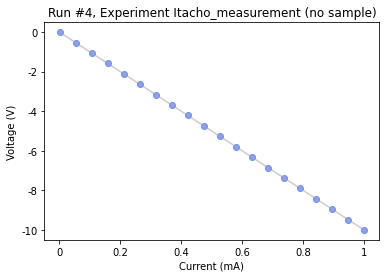

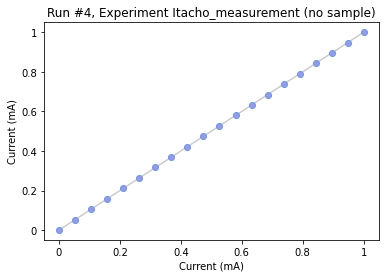

In [17]:
axes, cbax = plot_dataset(dataset)
for i in range(2):
    axes[i].lines[0].set_marker("o")
    axes[i].lines[0].set_markerfacecolor((0.6, 0.6, 0.9))
    axes[i].lines[0].set_markeredgecolor((0.4, 0.6, 0.9))
    axes[i].lines[0].set_color((0.8, 0.8, 0.8))

We see two results in the figure above; the first and second figures are the converted voltages and fed current, respectively against the swept current. If we look at our attached DMM, we see that it is showing -10.00 V DC, which is the same as the final voltage value in the first figure. Therefore, both results are as expected and showing that our Ithaco's virtual driver is performing as it should.

Let's explore our dataset, because why not :)

In [18]:
dataset.to_pandas_dataframe_dict()

{'curr':                             curr
 Keithley_smua_curr              
 0.000001            9.443364e-07
 0.000054            5.357243e-05
 0.000106            1.062108e-04
 0.000159            1.588324e-04
 0.000211            2.114506e-04
 0.000264            2.640623e-04
 0.000316            3.166975e-04
 0.000369            3.693167e-04
 0.000422            4.219315e-04
 0.000474            4.745453e-04
 0.000527            5.271591e-04
 0.000579            5.797739e-04
 0.000632            6.324015e-04
 0.000685            6.850098e-04
 0.000737            7.376224e-04
 0.000790            7.902317e-04
 0.000842            8.428346e-04
 0.000895            8.954364e-04
 0.000947            9.480564e-04
 0.001000            1.000660e-03,
 'volt_raw':                      volt_raw
 Keithley_smua_curr           
 0.000001            -0.009443
 0.000054            -0.535724
 0.000106            -1.062108
 0.000159            -1.588324
 0.000211            -2.114506
 0.000264     

In the above two tables, Keithley_smua_curr in both tables are the swept current values generated by our sourcemeter. The top table's second column (with the title curr) is showing the current values and the bottom table's second column (volt_raw) is showing voltage values of our Itacho's curr parameter.